## Introduction

The purpose of this notebook is running K-Means clustering to see if the algorithm can sucessfully cluster the news in to 'Real' & 'Fake' using just the words in the articles

## Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

In [ ]:
import pandas as pd
import io
from google.colab import files

## Data Analysis & Cleanup

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"rakibulshezan","key":"d6956859467d11693eb8f842bd380125"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name = 'fake-and-real-news-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
fake = pd.read_csv('/content/Fake.csv')
true = pd.read_csv('/content/True.csv')

In [ ]:
fake.head(10)

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
5   Racist Alabama Cops Brutalize Black Boy While...  ...  December 25, 2017
6   Fresh Off The Golf Course, Trump Lashes Out A...  ...  December 23, 2017
7   Trump Said Some INSANELY Racist Stuff Inside ...  ...  December 23, 2017
8   Former CIA Director Slams Trump Over UN Bully...  ...  December 22, 2017
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...  ...  December 21, 2017

[10 rows x 4 columns]

In [ ]:
true.head(10)

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 
5  White House, Congress prepare for talks on spe...  ...  December 29, 2017 
6  Trump says Russia probe will be fair, but time...  ...  December 29, 2017 
7  Factbox: Trump on Twitter (Dec 29) - Approval ...  ...  December 29, 2017 
8         Trump on Twitter (Dec 28) - Global Warming  ...  December 29, 2017 
9  Alabama official to certify Senator-elect Jone...  ...  December 28, 2017 

[10 rows x 4 columns]

The first issue as seen above is that the True data contains:

1. A reuters disclaimer that the article is a tweet
> "The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump"


2. City Name and then publisher at the start
> WASHINGTON (Reuters)

so in the next block of code I remove this from the data

In [ ]:
# The following is a crude way to remove the @realDonaldTrump tweet disclaimer and State/Publisher at start of text

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 
5  White House, Congress prepare for talks on spe...  ...  December 29, 2017 
6  Trump says Russia probe will be fair, but time...  ...  December 29, 2017 
7  Factbox: Trump on Twitter (Dec 29) - Approval ...  ...  December 29, 2017 
8         Trump on Twitter (Dec 28) - Global Warming  ...  December 29, 2017 
9  Alabama official to certify Senator-elect Jone...  ...  December 28, 2017 

[10 rows x 4 columns]

In [ ]:
true.text[7]

'While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers

So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [ ]:
# Merging title and text
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
final_data = pd.concat([fake, true])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

Sentences  Label
0  For Trump's defenders, White House turmoil is ...      1
1  WATCH: “HANOI JANE” FONDA Had Chance To Expose...      0
2  Rubio picks outgoing Devon executive to overse...      1
3  Afghan president says Trump war plan has bette...      1
4  Trump favors ex-pharma executive Azar for heal...      1
5  Trump to give remarks on healthcare at 12:55 p...      1
6  ANOTHER SOLDIER IN OBAMA’S RACE WAR: 4 White P...      0
7  Thailand says closely watching Myanmar crisis,...      1
8  ALARMING! THIS STATE’S SCHOOL SYSTEM TO TAKE O...      0
9   Woman Stabs Black Man In The Face On Christma...      0

In [ ]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['Sentences'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['Label'])

## Word2Vec

In [ ]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)

In [ ]:
model.wv.most_similar("country")

[('nation', 0.8139966130256653),
 ('america', 0.6586010456085205),
 ('countries', 0.5857846736907959),
 ('europe', 0.5521727800369263),
 ('world', 0.512537956237793),
 ('prosperous', 0.49553170800209045),
 ('path', 0.4851696789264679),
 ('abroad', 0.48186731338500977),
 ('realize', 0.47940945625305176),
 ('planet', 0.47784483432769775)]

## Sentence Vectors

In [ ]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
X_np = np.array(X)
X_np.shape

(44889, 100)

## Clustering

In [ ]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 468285.77871189953
start iteration
done sorting
end inner loop
Iteration 1, inertia 452114.6156813918
start iteration
done sorting
end inner loop
Iteration 2, inertia 447471.87555762404
start iteration
done sorting
end inner loop
Iteration 3, inertia 445591.6438128419
start iteration
done sorting
end inner loop
Iteration 4, inertia 444611.6718000603
start iteration
done sorting
end inner loop
Iteration 5, inertia 444115.83636671514
start iteration
done sorting
end inner loop
Iteration 6, inertia 443896.3324446566
start iteration
done sorting
end inner loop
Iteration 7, inertia 443814.21761317045
start iteration
done sorting
end inner loop
Iteration 8, inertia 443781.8260112659
start iteration
done sorting
end inner loop
Iteration 9, inertia 443769.1630912665
start iteration
done sorting
end inner loop
Iteration 10, inertia 443764.85278923996
start iteration
done sorting
end inner loop
Iteration 11,

In [ ]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

Sentence  Labels  Prediction
0  [trump, defenders, white, house, turmoil, poli...       1           0
1  [watch, “hanoi, jane”, fonda, chance, expose, ...       0           0
2  [rubio, picks, outgoing, devon, executive, ove...       1           1
3  [afghan, president, says, trump, war, plan, be...       1           1
4  [trump, favors, pharma, executive, azar, healt...       1           1
5  [trump, remarks, healthcare, gmt, white, house...       1           1
6  [soldier, obama’s, race, war, white, people, s...       0           0
7  [thailand, says, closely, watching, myanmar, c...       1           1
8  [alarming, state’s, school, everyday, parentin...       0           0
9  [woman, stabs, black, man, face, christmas, of...       0           0

The results above show that its correctly clustered them in some cases where 0 is fake news and 1 is real news

In [ ]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 87.39334803626724%


## Visualization

In [ ]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [ ]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

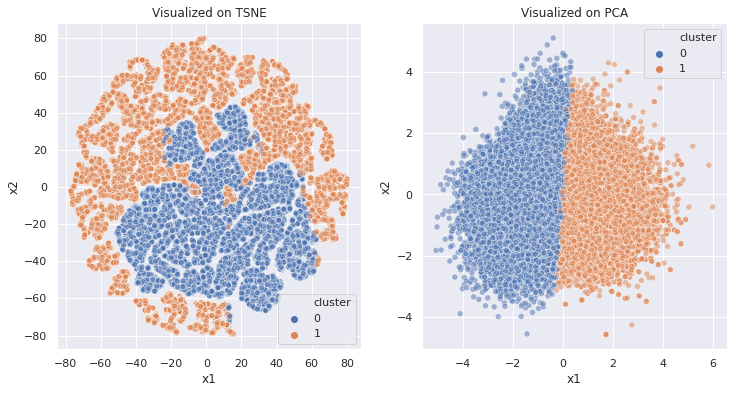

In [ ]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [ ]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "Flint Residents Learn To Harness Superpowers, But Trump Gets Away Again They developed superpowers after years of drinking from a lead-poisoned water supply. But just having incredible abilities doesn't make them superheroes. Not yet. Donald Trump faced off against the superpowered civilians but he got away before they could catch him"

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = Sentence_Vector(onion_data)

# Get prediction
kmeans.predict(np.array([onion_data]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([0], dtype=int32)

In [ ]:
# News from BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = Sentence_Vector(bbc_data)

# Get prediction
kmeans.predict(np.array([bbc_data]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1], dtype=int32)